In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = torch.sigmoid(self.fc_probs(x))
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        bern_dist = torch.distributions.Bernoulli(probs_x)
        x_recon = bern_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [5]:
LATENT_DIM = 16

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:07<02:22,  7.49s/it]

Epoch 1, Mean Training ELBO 196.567938046875, Mean Validation ELBO 160.54171826171876


 10%|█         | 2/20 [00:13<01:56,  6.46s/it]

Epoch 2, Mean Training ELBO 137.36269990234376, Mean Validation ELBO 129.73930710449218


 15%|█▌        | 3/20 [00:19<01:44,  6.16s/it]

Epoch 3, Mean Training ELBO 119.23423384765626, Mean Validation ELBO 116.42155815429687


 20%|██        | 4/20 [00:24<01:36,  6.03s/it]

Epoch 4, Mean Training ELBO 112.479592421875, Mean Validation ELBO 111.52158367919922


 25%|██▌       | 5/20 [00:30<01:29,  5.96s/it]

Epoch 5, Mean Training ELBO 109.49432603515625, Mean Validation ELBO 109.99063776855469


 30%|███       | 6/20 [00:36<01:22,  5.90s/it]

Epoch 6, Mean Training ELBO 107.0759549609375, Mean Validation ELBO 107.88283605957031


 35%|███▌      | 7/20 [00:42<01:16,  5.87s/it]

Epoch 7, Mean Training ELBO 105.560262578125, Mean Validation ELBO 106.53851270751953


 40%|████      | 8/20 [00:48<01:10,  5.85s/it]

Epoch 8, Mean Training ELBO 104.50341349609376, Mean Validation ELBO 105.92266926269531


 45%|████▌     | 9/20 [00:53<01:04,  5.83s/it]

Epoch 9, Mean Training ELBO 103.574528828125, Mean Validation ELBO 104.77522712402343


 50%|█████     | 10/20 [00:59<00:58,  5.83s/it]

Epoch 10, Mean Training ELBO 103.00438095703124, Mean Validation ELBO 104.89187573242188


 55%|█████▌    | 11/20 [01:05<00:52,  5.83s/it]

Epoch 11, Mean Training ELBO 102.27080306640624, Mean Validation ELBO 103.47548420410156


 60%|██████    | 12/20 [01:11<00:46,  5.83s/it]

Epoch 12, Mean Training ELBO 101.81369823242187, Mean Validation ELBO 102.96071694335937


 65%|██████▌   | 13/20 [01:17<00:40,  5.83s/it]

Epoch 13, Mean Training ELBO 101.2600607421875, Mean Validation ELBO 102.6894341796875


 70%|███████   | 14/20 [01:23<00:35,  5.83s/it]

Epoch 14, Mean Training ELBO 100.97379701171874, Mean Validation ELBO 102.53216635742187


 75%|███████▌  | 15/20 [01:28<00:29,  5.83s/it]

Epoch 15, Mean Training ELBO 100.54462518554688, Mean Validation ELBO 102.11764523925781


 80%|████████  | 16/20 [01:34<00:23,  5.85s/it]

Epoch 16, Mean Training ELBO 100.10024395507813, Mean Validation ELBO 102.64843063964844


 85%|████████▌ | 17/20 [01:40<00:17,  5.85s/it]

Epoch 17, Mean Training ELBO 99.882172734375, Mean Validation ELBO 101.64416658935546


 90%|█████████ | 18/20 [01:46<00:11,  5.85s/it]

Epoch 18, Mean Training ELBO 99.66621228515625, Mean Validation ELBO 101.61988352050781


 95%|█████████▌| 19/20 [01:52<00:05,  5.86s/it]

Epoch 19, Mean Training ELBO 99.3483465625, Mean Validation ELBO 101.48392962646484


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]

Epoch 20, Mean Training ELBO 99.09796098632812, Mean Validation ELBO 102.12376688232422


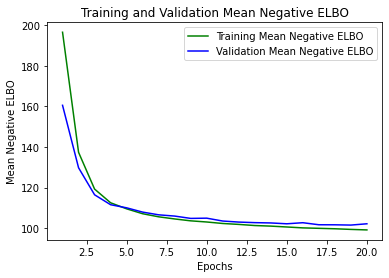

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20)

In [46]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        x_recon = vae.reconstruct(probs_x)
        # x_recon = probs_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

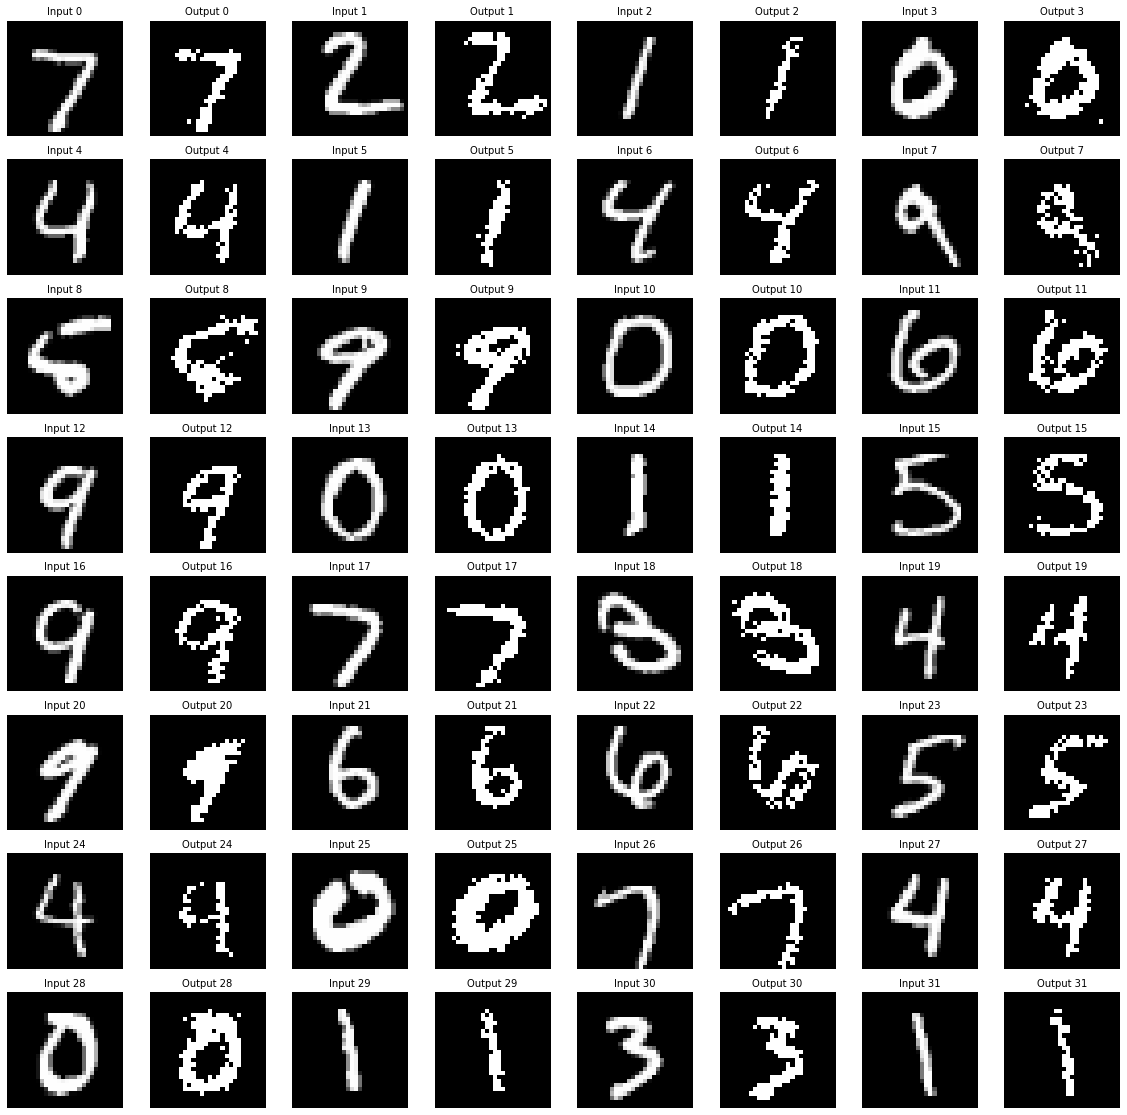

In [47]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(BATCH_SIZE, 28, 28)
    x_recon = x_recon.view(BATCH_SIZE, 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

In [30]:
train_x_gauss = test_x[:400]
val_x_gauss = test_x[400:500]
test_x_gauss = test_x[500:]
train_y_gauss = test_y[:400]
val_y_gauss = test_y[400:500]
test_y_gauss = test_y[500:]

train_data_gauss = TensorDataset(train_x_gauss, train_y_gauss)
val_data_gauss = TensorDataset(val_x_gauss, val_y_gauss)
test_data_gauss = TensorDataset(test_x_gauss, test_y_gauss)

train_dataloader_gauss = DataLoader(train_data_gauss, batch_size=1, shuffle=True)
val_dataloader_gauss = DataLoader(val_data_gauss, batch_size=1, shuffle=True)
test_dataloader_gauss = DataLoader(test_data_gauss, batch_size=BATCH_SIZE)

In [52]:
class Gaussian(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc_mu = nn.Linear(input_dim, latent_dim)
        self.fc_var = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

In [57]:
gaussian = Gaussian(input_dim=IMG_C*IMG_H*IMG_W, latent_dim=LATENT_DIM).to(DEVICE)
print(gaussian)
for param in decoder.parameters():
    param.requires_grad = False

Gaussian(
  (fc_mu): Linear(in_features=784, out_features=16, bias=True)
  (fc_var): Linear(in_features=784, out_features=16, bias=True)
)


  2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

Epoch 1, Mean Training ELBO 269.1141206932068, Mean Validation ELBO 200.69698097229005


  4%|▍         | 2/50 [00:03<01:15,  1.57s/it]

Epoch 2, Mean Training ELBO 168.77697756767273, Mean Validation ELBO 172.99538375854493


  6%|▌         | 3/50 [00:04<01:13,  1.55s/it]

Epoch 3, Mean Training ELBO 153.65693157196046, Mean Validation ELBO 165.2460279083252


  8%|▊         | 4/50 [00:06<01:11,  1.54s/it]

Epoch 4, Mean Training ELBO 146.92627240180968, Mean Validation ELBO 163.67630867004394


 10%|█         | 5/50 [00:07<01:09,  1.54s/it]

Epoch 5, Mean Training ELBO 145.7377199935913, Mean Validation ELBO 167.9720712661743


 12%|█▏        | 6/50 [00:09<01:08,  1.55s/it]

Epoch 6, Mean Training ELBO 142.90115991592407, Mean Validation ELBO 163.8072234725952


 14%|█▍        | 7/50 [00:10<01:07,  1.57s/it]

Epoch 7, Mean Training ELBO 141.95281161308287, Mean Validation ELBO 164.65849781036377


 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

Epoch 8, Mean Training ELBO 140.5769463920593, Mean Validation ELBO 161.79826389312746


 18%|█▊        | 9/50 [00:14<01:04,  1.57s/it]

Epoch 9, Mean Training ELBO 139.9252063369751, Mean Validation ELBO 163.67114597320557


 20%|██        | 10/50 [00:15<01:02,  1.56s/it]

Epoch 10, Mean Training ELBO 139.5920665740967, Mean Validation ELBO 158.0813483810425


 22%|██▏       | 11/50 [00:17<01:00,  1.55s/it]

Epoch 11, Mean Training ELBO 137.70038208961486, Mean Validation ELBO 160.03615364074707


 24%|██▍       | 12/50 [00:18<00:58,  1.54s/it]

Epoch 12, Mean Training ELBO 138.1085398864746, Mean Validation ELBO 164.0591082763672


 26%|██▌       | 13/50 [00:20<00:56,  1.54s/it]

Epoch 13, Mean Training ELBO 136.67725723266602, Mean Validation ELBO 164.57114627838135


 28%|██▊       | 14/50 [00:21<00:55,  1.54s/it]

Epoch 14, Mean Training ELBO 136.74311560630798, Mean Validation ELBO 160.3022780609131


 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

Epoch 15, Mean Training ELBO 136.41706625938414, Mean Validation ELBO 162.70771587371826


 32%|███▏      | 16/50 [00:24<00:53,  1.56s/it]

Epoch 16, Mean Training ELBO 135.86212062835693, Mean Validation ELBO 165.04786151885986


 34%|███▍      | 17/50 [00:26<00:51,  1.57s/it]

Epoch 17, Mean Training ELBO 134.73985975265504, Mean Validation ELBO 164.3325360107422


 36%|███▌      | 18/50 [00:28<00:50,  1.57s/it]

Epoch 18, Mean Training ELBO 135.29149745941163, Mean Validation ELBO 160.71731647491455


 38%|███▊      | 19/50 [00:29<00:48,  1.55s/it]

Epoch 19, Mean Training ELBO 135.82880235671996, Mean Validation ELBO 161.05129333496095


 40%|████      | 20/50 [00:31<00:47,  1.58s/it]

Epoch 20, Mean Training ELBO 133.39150021553039, Mean Validation ELBO 165.5871199798584


 42%|████▏     | 21/50 [00:32<00:45,  1.57s/it]

Epoch 21, Mean Training ELBO 133.67712651252748, Mean Validation ELBO 160.89683429718016


 44%|████▍     | 22/50 [00:34<00:43,  1.56s/it]

Epoch 22, Mean Training ELBO 133.6375311756134, Mean Validation ELBO 162.78427040100098


 46%|████▌     | 23/50 [00:35<00:41,  1.55s/it]

Epoch 23, Mean Training ELBO 133.33575352668763, Mean Validation ELBO 164.07882095336913


 48%|████▊     | 24/50 [00:37<00:40,  1.55s/it]

Epoch 24, Mean Training ELBO 132.2345863342285, Mean Validation ELBO 163.11214550018312


 50%|█████     | 25/50 [00:38<00:38,  1.54s/it]

Epoch 25, Mean Training ELBO 132.60794445991516, Mean Validation ELBO 163.49132034301758


 52%|█████▏    | 26/50 [00:40<00:38,  1.58s/it]

Epoch 26, Mean Training ELBO 132.14317833900452, Mean Validation ELBO 163.44296169281006


 54%|█████▍    | 27/50 [00:42<00:36,  1.60s/it]

Epoch 27, Mean Training ELBO 132.04570757865906, Mean Validation ELBO 162.85134712219238


 56%|█████▌    | 28/50 [00:43<00:34,  1.59s/it]

Epoch 28, Mean Training ELBO 132.03298728942872, Mean Validation ELBO 165.04797836303712


 58%|█████▊    | 29/50 [00:45<00:33,  1.59s/it]

Epoch 29, Mean Training ELBO 131.91380352973937, Mean Validation ELBO 163.49229320526123


 60%|██████    | 30/50 [00:46<00:31,  1.57s/it]

Epoch 30, Mean Training ELBO 133.11702083587647, Mean Validation ELBO 162.99700843811036


 62%|██████▏   | 31/50 [00:48<00:29,  1.56s/it]

Epoch 31, Mean Training ELBO 130.82486083984375, Mean Validation ELBO 164.0688946533203


 64%|██████▍   | 32/50 [00:49<00:27,  1.55s/it]

Epoch 32, Mean Training ELBO 130.5013384437561, Mean Validation ELBO 166.3032364654541


 66%|██████▌   | 33/50 [00:51<00:26,  1.55s/it]

Epoch 33, Mean Training ELBO 130.75443803787232, Mean Validation ELBO 162.2149352645874


 68%|██████▊   | 34/50 [00:53<00:24,  1.55s/it]

Epoch 34, Mean Training ELBO 130.4011335849762, Mean Validation ELBO 166.99296695709228


 70%|███████   | 35/50 [00:54<00:23,  1.54s/it]

Epoch 35, Mean Training ELBO 130.63632207870484, Mean Validation ELBO 161.5108679962158


 72%|███████▏  | 36/50 [00:56<00:21,  1.55s/it]

Epoch 36, Mean Training ELBO 130.36692031860352, Mean Validation ELBO 164.42766159057618


 74%|███████▍  | 37/50 [00:57<00:20,  1.58s/it]

Epoch 37, Mean Training ELBO 130.4504965019226, Mean Validation ELBO 161.3495434951782


 76%|███████▌  | 38/50 [00:59<00:19,  1.61s/it]

Epoch 38, Mean Training ELBO 129.83543231010438, Mean Validation ELBO 164.76259769439696


 78%|███████▊  | 39/50 [01:01<00:18,  1.64s/it]

Epoch 39, Mean Training ELBO 130.15648913383484, Mean Validation ELBO 166.99458068847656


 80%|████████  | 40/50 [01:02<00:16,  1.61s/it]

Epoch 40, Mean Training ELBO 129.73425943374633, Mean Validation ELBO 164.505671043396


 82%|████████▏ | 41/50 [01:04<00:14,  1.60s/it]

Epoch 41, Mean Training ELBO 130.12444224357606, Mean Validation ELBO 163.55625102996825


 84%|████████▍ | 42/50 [01:05<00:12,  1.58s/it]

Epoch 42, Mean Training ELBO 128.9564249229431, Mean Validation ELBO 165.27400943756103


 86%|████████▌ | 43/50 [01:07<00:10,  1.57s/it]

Epoch 43, Mean Training ELBO 129.29306087493896, Mean Validation ELBO 163.8173854446411


 88%|████████▊ | 44/50 [01:08<00:09,  1.56s/it]

Epoch 44, Mean Training ELBO 130.12455491065978, Mean Validation ELBO 164.82695266723633


 90%|█████████ | 45/50 [01:10<00:07,  1.55s/it]

Epoch 45, Mean Training ELBO 129.55706412315368, Mean Validation ELBO 164.77320137023926


 92%|█████████▏| 46/50 [01:11<00:06,  1.55s/it]

Epoch 46, Mean Training ELBO 129.11765251159667, Mean Validation ELBO 166.25946311950685


 94%|█████████▍| 47/50 [01:13<00:04,  1.55s/it]

Epoch 47, Mean Training ELBO 128.2064589881897, Mean Validation ELBO 167.1979780960083


 96%|█████████▌| 48/50 [01:15<00:03,  1.55s/it]

Epoch 48, Mean Training ELBO 128.7382752799988, Mean Validation ELBO 166.43899555206298


 98%|█████████▊| 49/50 [01:16<00:01,  1.55s/it]

Epoch 49, Mean Training ELBO 128.88083742141723, Mean Validation ELBO 168.8000156021118


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]

Epoch 50, Mean Training ELBO 128.45002702713012, Mean Validation ELBO 165.88563148498534


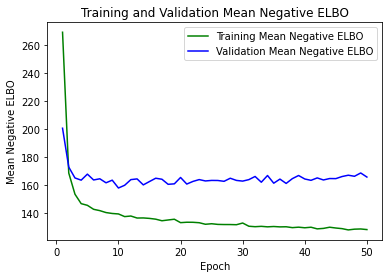

In [58]:
optimizer_gaussian = torch.optim.Adam(gaussian.parameters(), lr=1e-3)

def train_gaussian(num_epochs, patience=50):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader_gauss:
            optimizer_gaussian.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            x = torch.flatten(x, start_dim=1)
            z, mu_z, log_var_z = gaussian(x)
            probs_x = decoder(z)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer_gaussian.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader_gauss:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                x = torch.flatten(x, start_dim=1)
                z, mu_z, log_var_z = gaussian(x)
                probs_x = decoder(z)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / 400
        mean_val_elbo = overall_val_elbo / 100
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_gaussian(num_epochs=50)

In [1]:
def test_gaussian():
    x, _ = next(iter(test_dataloader_gauss))
    x = x.to(DEVICE)
    with torch.no_grad():
        x = torch.flatten(x, start_dim=1)
        z, _, _ = gaussian(x)
        probs_x = decoder(z)
        x_recon = probs_x
        return x, x_recon
test_batch_gauss, test_batch_recon_gauss = test_gaussian()

NameError: name 'test_dataloader_gauss' is not defined

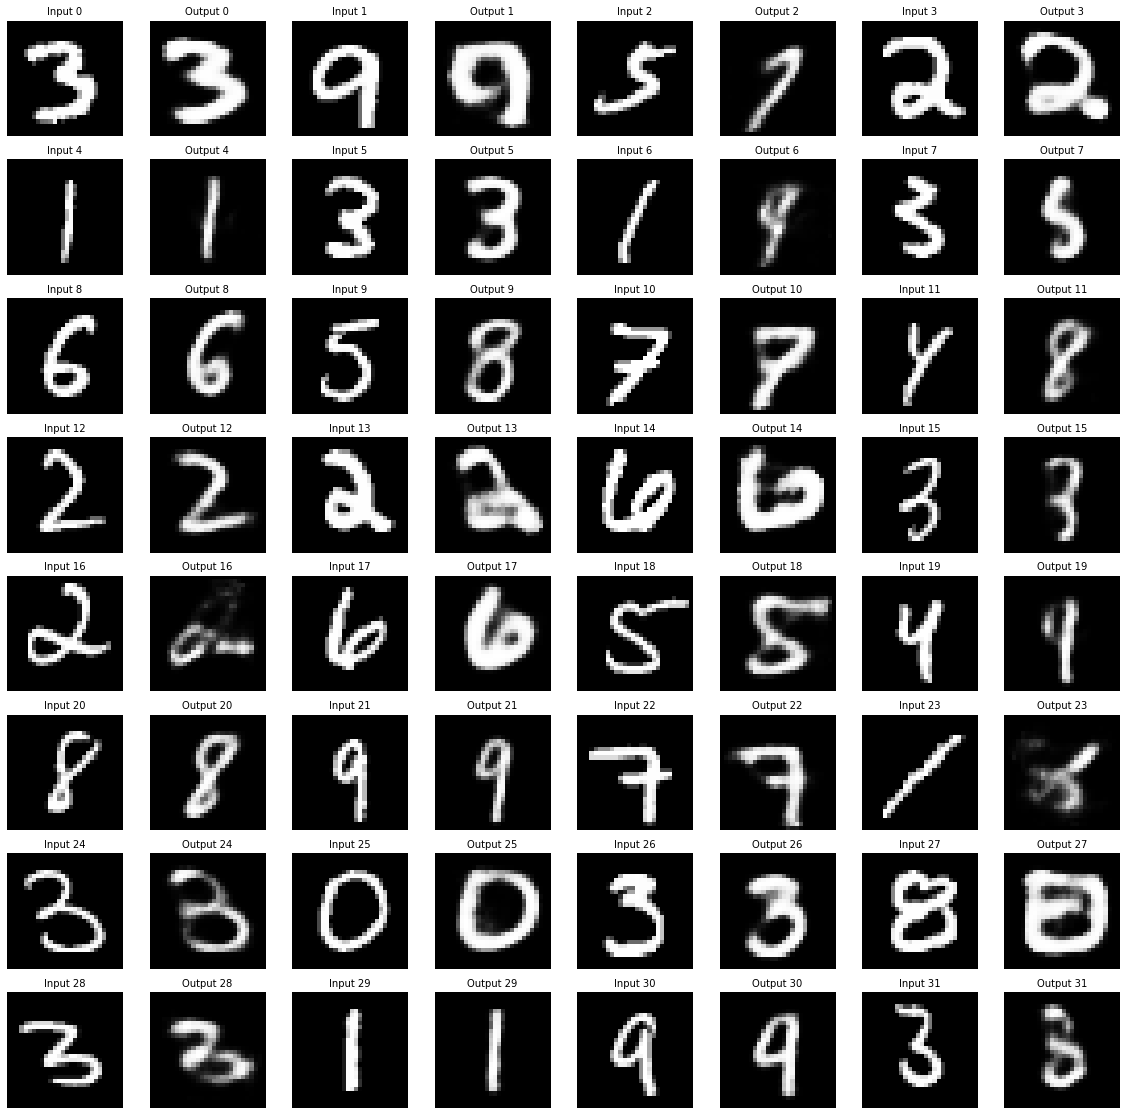

In [60]:
show_images(test_batch_gauss, test_batch_recon_gauss)